In [1]:
# Import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Quiet setting warnings
pd.options.mode.chained_assignment = None

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# Notebook Description
This notebook is used to create the data sets that will be used for breakout/prediction classification models. First, we will merge all relevant data that has been collected via webscraping. Second, we will create our "breakout" and "bust" target variables through use of linear regression.

# Merging ADP, Season Statistics, & QB ADP Information

Here we merge pre-season ADP, season statistics (which provide our target information), and QB ADP information. Overall, the goal of this project is to use only pre-season information to predict in-season results. This should allow us to forecast future seasons.

In [2]:
# Import raw data
adp_df = pd.read_csv(os.getcwd() + "/../data/myfantasyleague-adp-data-2013-2022.csv")
stats_df = pd.read_csv(os.getcwd() + "/../data/season-statistics-2013-2022.csv")
qb_df = pd.read_csv(os.getcwd() + "/../data/myfantasyleague-qb-adp-data-2013-2022.csv")
draft_df = pd.read_csv(os.getcwd() + "/../data/draft-information-2000-2022.csv")

In [3]:
# Merge ADP, season performance, and QB information
mergedData = adp_df.merge(stats_df, how='inner')
mergedData = mergedData.merge(qb_df[['Team', 'Year', 'TopQB_ADP']], how='inner')
mergedData = mergedData.merge(draft_df[['FirstName', 'LastName', 'Pos', 'DraftYear']], how='inner')

# Select and order columns
df = mergedData[[
    'Year', 'FirstName', 'LastName', 'Team', 'Position', 'Age', 'DraftYear', 'GamesPlayed', 'ADP', 
    'TeamPosRank', 'PosRank1_ADP', 'PosRank2_ADP', 'PosAmbiguity', 'TopQB_ADP', 'PPG_HalfPPR']]

# Filter data for specific project purpose
df = df.loc[(df.ADP <= 120) & (df.GamesPlayed > 8) & (df.Position != 'TE')]

# Inferring Rookie & Second Year Info from Draft Data

In [4]:
df['RookieSeason'] = np.where(df.Year == df.DraftYear, 1, 0)
df['SecondSeason'] = np.where(df.Year == df.DraftYear + 1, 1, 0)

# ADP vs PPG

Text(0.5, 1.0, 'Wide Receivers')

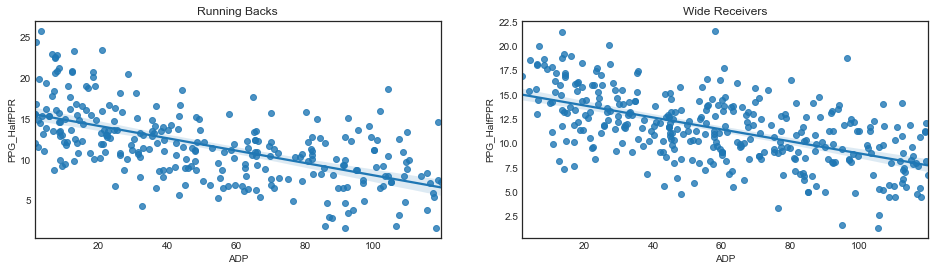

In [5]:
plt.style.use('seaborn-white')
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.regplot(data=df.loc[df.Position == 'RB'], x='ADP', y='PPG_HalfPPR', ax=ax[0])
sns.regplot(data=df.loc[df.Position == 'WR'], x='ADP', y='PPG_HalfPPR', ax=ax[1])
ax[0].set_title('Running Backs')
ax[1].set_title('Wide Receivers')

# ADP-Based PPG Expectation
To define breakout or bust performances we need assign some sort of player expectations. Of course, player expectation is dependent on ADP. For example, we expect players drafted in the earlier rounds to score more than players drafted in the later rounds. We see this in the plots above. With this being said, I will use a simple and intuitive process to set individual player expectations. I will use linear regression to model a player's PPG based on their ADP (for each position separately). I will then use the model to "predict" (or quantify) a player's ADP-based expectation.

# Breakout/Bust Determination
Breakouts will only be considered for rounds 3-10 since players drafted in rounds 1 and 2 have likely already broken out. Busts will only be considered rounds 1-7 since the opportunity cost (with regard to missing on a pick) is much lower after round 7. Breakouts and busts will be defined using the following criteria:

- **Breakouts**: Players who outscore their expectation by over 130% (PPG/ExpectedPPG > 1.3)
- **Busts**: Players who score under 75% of their expectation (PPG/ExpectedPPG < 0.75)

**NOTE**: These thresholds are very much arbitrary, however, and can be adjusted if need be

In [6]:
def get_expectedPPG(df):
    '''
    Function to determine expected PPG using a linear regression approach.
    Returns a data frame containing expected PPG which can be used to determine breakout/bust information.
    '''
    
    # Prepare data for linear regression
    x = df['ADP'].to_numpy()
    x = sm.add_constant(x)
    y = df['PPG_HalfPPR'].to_numpy()
    
    # Fit OLS model
    lr_model = sm.OLS(y, x).fit()
    
    # Determine expected PPG and define breakout/bust variables
    df['Expected_PPG_HalfPPR'] = lr_model.predict(x)
    df['PPG_/_ExpPPG'] = df.PPG_HalfPPR / df.Expected_PPG_HalfPPR
    df['Expected_PPG_HalfPPR'] = df['Expected_PPG_HalfPPR'].round(3)
    df['PPG_/_ExpPPG'] = df['PPG_/_ExpPPG'].round(3)
    
    return df
    

## Running Back Breakouts

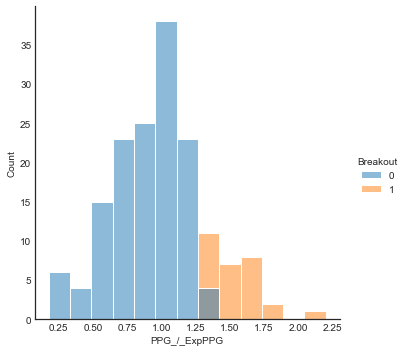

In [7]:
# Prepare data for linear regression
rb_breakout_df = get_expectedPPG(df.loc[(df.Position == 'RB') & (df.ADP >= 36)])
rb_breakout_df['Breakout'] = np.where(rb_breakout_df['PPG_/_ExpPPG'] > 1.30, 1, 0)

# Visualize distribution of PPG/ExpPPG
plt.style.use('seaborn-white')
sns.displot(rb_breakout_df, x='PPG_/_ExpPPG', edgecolor='white', hue='Breakout')

## Wide Receiver Breakouts

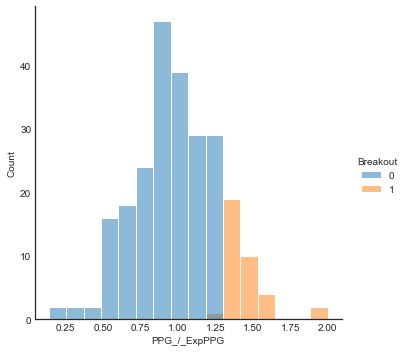

In [8]:
# Prepare data for linear regression
wr_breakout_df = get_expectedPPG(df.loc[(df.Position == 'WR') & (df.ADP >= 36)])
wr_breakout_df['Breakout'] = np.where(wr_breakout_df['PPG_/_ExpPPG'] > 1.30, 1, 0)

# Visualize distribution of PPG/ExpPPG
plt.style.use('seaborn-white')
sns.displot(wr_breakout_df, x='PPG_/_ExpPPG', edgecolor='white', hue='Breakout')

## Running Back Busts

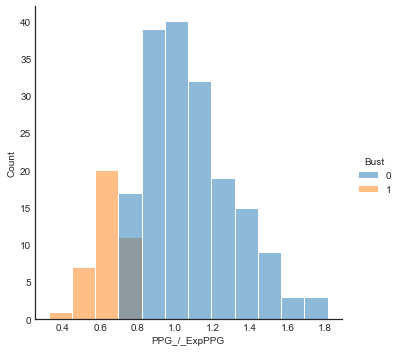

In [9]:
# Prepare data for linear regression
rb_bust_df = get_expectedPPG(df.loc[(df.Position == 'RB') & (df.ADP <= 84)])
rb_bust_df['Bust'] = np.where(rb_bust_df['PPG_/_ExpPPG'] < 0.75, 1, 0)

# Visualize distribution of PPG/ExpPPG
plt.style.use('seaborn-white')
sns.displot(rb_bust_df, x='PPG_/_ExpPPG', edgecolor='white', hue='Bust')

## Wide Receiver Busts

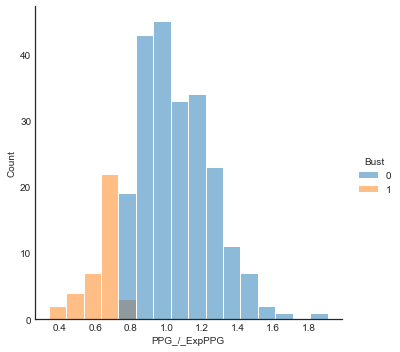

In [10]:
# Prepare data for linear regression
wr_bust_df = get_expectedPPG(df.loc[(df.Position == 'WR') & (df.ADP <= 84)])
wr_bust_df['Bust'] = np.where(wr_bust_df['PPG_/_ExpPPG'] < 0.75, 1, 0)

# Visualize distribution of PPG/ExpPPG
plt.style.use('seaborn-white')
sns.displot(wr_bust_df, x='PPG_/_ExpPPG', edgecolor='white', hue='Bust')

## Visualizing Breakouts & Busts
### Breakouts

Text(0.5, 1.0, 'WR Breakouts')

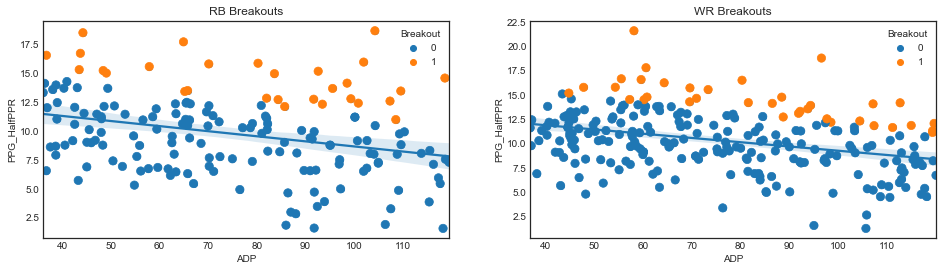

In [11]:
# Figure space
plt.style.use('seaborn-white')
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# RB Breakouts
sns.regplot(data=rb_breakout_df, x='ADP', y='PPG_HalfPPR', color=None, ax=ax[0])
sns.scatterplot(data=rb_breakout_df, x='ADP', y='PPG_HalfPPR', edgecolor=None, hue='Breakout', s=70, ax=ax[0])

# WR Breatkouts
sns.regplot(data=wr_breakout_df, x='ADP', y='PPG_HalfPPR', color=None, ax=ax[1])
sns.scatterplot(data=wr_breakout_df, x='ADP', y='PPG_HalfPPR', edgecolor=None, hue='Breakout', s=70, ax=ax[1])

# Labels
ax[0].set_title('RB Breakouts')
ax[1].set_title('WR Breakouts')

### Busts

Text(0.5, 1.0, 'WR Busts')

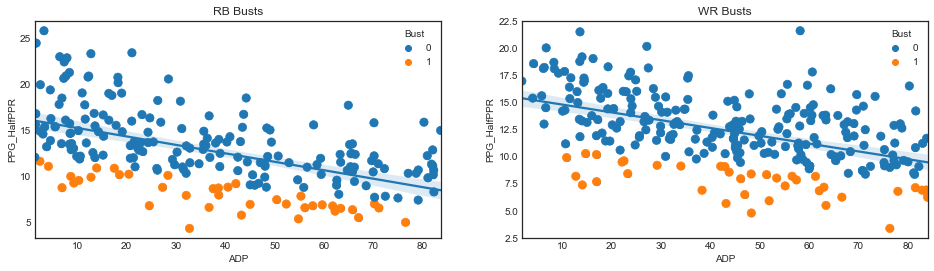

In [12]:
# Figure space
plt.style.use('seaborn-white')
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# RB Breakouts
sns.regplot(data=rb_bust_df, x='ADP', y='PPG_HalfPPR', color=None, ax=ax[0])
sns.scatterplot(data=rb_bust_df, x='ADP', y='PPG_HalfPPR', edgecolor=None, hue='Bust', s=70, ax=ax[0])

# WR Breatkouts
sns.regplot(data=wr_bust_df, x='ADP', y='PPG_HalfPPR', color=None, ax=ax[1])
sns.scatterplot(data=wr_bust_df, x='ADP', y='PPG_HalfPPR', edgecolor=None, hue='Bust', s=70, ax=ax[1])

# Labels
ax[0].set_title('RB Busts')
ax[1].set_title('WR Busts')

# Output Datasets

In [13]:
rb_breakout_df.to_csv('./processed-data/rb-breakout-data.csv', index=False)
wr_breakout_df.to_csv('./processed-data/wr-breakout-data.csv', index=False)
rb_bust_df.to_csv('./processed-data/rb-bust-data.csv', index=False)
wr_bust_df.to_csv('./processed-data/wr-bust-data.csv', index=False)